## THIS NOTEBOOK
In this notebook the algorithm, implemented in 11_clustering_Louvain_and_maximum_likelihood, is sligthly modified in order to return two values for every stock, instead of the retun, risk and sharp rateo. This two values are:
* The stock relative weight inside the cluster (range from 0 to 1).
* The  (stock's) cluster weight in the portfolio.
This values are a sufficient caracterisation of a portfolio and this way we are able to compute the return even on a different return dataframe, proceding as follow:
$$Return(\{portfolio\}) = \sum_{cluster = i}[W_{Ci}\sum_{stock_{Ci} = j}[{W_{i,j}*Return_{j}} ]] = \sum_{stock = j}[{W_{Ci}*W_{i,j}*Return_{j}} ]$$
This modification allows us to perform tests on the stability of the different methods by acting as follows:
* We split the dataframe in time period of N days, creating #Rows/N subdataframes.
* For every subdataframes(time = i) we compute the optimal porfolio(at t=i) given a certain strategy.
* We test the performance of the porfolio(t=i) on the returns at time (t = i+1)
* we compute the returns of the dinamic portfolio build with the previously described strategy, it's annual risk, and it's annual return.

In [1]:
#magic functions
%load_ext autoreload
%autoreload 2

#imports
from helpers import *

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

#math
from numpy import linalg as LA
import numpy as np
import pandas as pd
import math
import random

#utils
import itertools
import copy

#louvian clustering
import networkx as nx
import community
import community.community_louvain as community_louvain

#Maximum likelyhood clustering
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri

#Portfolio optimization (Markovitz)
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
#R-brigde
from rpy2.robjects.packages import importr
#stats
import scipy

In [2]:
DF=pd.read_parquet("us_equities_logreturns.parquet")

DF_cut = drop_nans(DF)

DF = DF_cut

display(DF.head(5))

,^GSPC,GE,IBM,DIS,BA,CAT,AA,HPQ,DD,KO,...,NBL,MAT,JCP,AVT,THC,GRA,LPX,VLO,WMB,TXI
8033,-0.022160,0.000000,-0.022696,0.000000,-0.030214,-0.006135,-0.013606,-0.029414,-0.026387,0.000000,...,-0.024693,-0.047791,0.00000,-0.010292,0.006810,0.000000,0.000000,-0.012270,-0.048790,-0.003431
8034,-0.007273,-0.021506,-0.004313,-0.012739,0.000000,-0.003082,-0.006873,-0.015038,-0.005362,0.000000,...,-0.051293,0.000000,0.00000,-0.003454,-0.034526,0.000000,-0.005970,-0.063716,-0.025318,-0.006897
8035,-0.002100,0.021506,0.000000,-0.012903,-0.012346,0.006154,-0.006920,0.029853,-0.005391,0.030772,...,-0.042233,0.106060,0.02353,0.005177,-0.007051,0.000000,0.011905,-0.026668,0.000000,-0.006944
8036,0.005200,0.000000,0.000000,0.000000,0.000000,0.006116,0.006920,0.057158,0.000000,0.029853,...,0.007813,0.043084,0.00000,-0.005177,0.007051,0.000000,-0.023953,0.013423,0.000000,0.006944
8037,-0.023443,-0.021506,0.000000,-0.039740,-0.031548,-0.024693,-0.013889,-0.064539,-0.021859,-0.029853,...,-0.027615,-0.062132,-0.02353,0.000000,-0.029711,-0.287682,-0.018349,-0.068993,-0.052644,-0.013938


## Louvain clustering

In [3]:
def compute_C_minus_C0(lambdas,v,lambda_plus):
    N=len(lambdas)
    C_clean=np.zeros((N, N))
    
    v_m=np.matrix(v)

    # _s stands for _structure below: 
    for i in range(N-1):
        if lambdas[i]>lambda_plus:
            C_clean=C_clean+lambdas[i] * np.dot(v_m[:,i],v_m[:,i].T)  
    return C_clean    
    

In [4]:
def LouvainCorrelationClustering(R):   # R is a matrix of return
    """Given a retun matrix performs Louvain Correlation Clustering"""
    N=R.shape[1]
    T=R.shape[0]
    
    #Perform Louvain Correlation Clustering
    q=N*1./T
    lambda_plus=(1.+np.sqrt(q))**2

    C=R.corr()
    lambdas, v = LA.eigh(C)

    order = np.argsort(lambdas)
    lambdas,v = lambdas[order],v[:,order]
      
    C_s=compute_C_minus_C0(lambdas,v,lambda_plus)
    mygraph= nx.from_numpy_matrix(np.abs(C_s))
    partition = community.community_louvain.best_partition(mygraph)

    df=pd.DataFrame.from_dict(partition,orient="index")
    
    #Rewrite results in a nice format
    df['StockName'] = R.columns
    df = df.reset_index()
    df = df.drop(columns = 'index')
    df = df.rename({0: 'Cluster'},axis = 'columns')
    df = df.set_index('StockName')
    
    return(df)

In [5]:
clust_louvain=LouvainCorrelationClustering(DF_cut)
display(clust_louvain.head(5))

,Cluster
StockName,
^GSPC,0
GE,1
IBM,0
DIS,0
BA,2


## Maximum likelihood clustering


There is no code for this method in Python. The following shows how to call R from Python.

### If It's the first time you use rpy2 then you need to:
1) install R https://cran.rstudio.com/
2) run: !pip install rpy2


In [6]:
# Run only once!!!
utils = importr('utils')
utils.install_packages("data.table")

--- Per piacere, seleziona un mirror CRAN per la sessione ---


From cffi callback <function _consolewrite_ex at 0x000001FFFF7BACA8>:
Traceback (most recent call last):
  File "C:\Users\mauro\Anaconda3\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 132, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "C:\Users\mauro\Anaconda3\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 133, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 78: invalid continuation byte
R[write to console]: trying URL 'https://stat.ethz.ch/CRAN/bin/windows/contrib/4.1/data.table_1.14.2.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 2600354 bytes (2.5 MB)

R[write to console]: downloaded 2.5 MB




package 'data.table' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\mauro\AppData\Local\Temp\RtmpK24lGZ\downloaded_packages


<rpy2.rinterface_lib.sexp.NULLType object at 0x000001FFFF9A7F08> [RTYPES.NILSXP]

In [7]:
#From r package import a python function aggregateClusters able to perform maximum likelyhood clustering
r = robjects.r
importr("data.table")
newfunc = r.source("libClusteringGiadaMarsiliFast.R")
aggregateClusters=robjects.globalenv["aggregateClusters"]
rpy2.robjects.numpy2ri.activate()

In [8]:
def aggregateClusters_(R,aggregateClusters=aggregateClusters):
    """Slight modification to the original function taken from "libClusteringGiadaMarsiliFast.R" package.
    The modification is made in order to simplify the use and to produce the output with the same format as
    the previous clustering method"""
    C = R.corr()
    intermediate_result = aggregateClusters(C.values)
    nb_clusters = len(intermediate_result[3])
    ls_dfs = []
    for i in range(nb_clusters):
        df = pd.DataFrame(np.array(intermediate_result[3][i]),columns = ['StockName'])
        df['Cluster'] = i
        ls_dfs.append(df)
    df = pd.concat(ls_dfs,ignore_index=True)
    dict_N_to_Stockname = dict(zip(range(1,len(list(R.columns))+1), R.columns))
    df['StockName'] = df['StockName'].apply(lambda number: dict_N_to_Stockname[number])
    
    df = df.reset_index()
    df = df.drop(columns = 'index')
    df = df.set_index('StockName')

    return df

In [9]:
print('Max Likelyhood Clustering output:')
display(aggregateClusters_(DF_cut))
print('-------------------------------------------------------------------')
print('Louvain Correlation Clustering output:')
display(LouvainCorrelationClustering(DF_cut))

Max Likelyhood Clustering output:


,Cluster
StockName,
^GSPC,0
GE,0
AXP,0
C,0
DD,0
...,...
MAT,13
THC,14
GRA,15


-------------------------------------------------------------------
Louvain Correlation Clustering output:


,Cluster
StockName,
^GSPC,0
GE,1
IBM,0
DIS,0
BA,2
...,...
GRA,3
LPX,3
VLO,1


## Comparaison of performance of different techniques to create portfolio
To create a portfolio starting from a set of data indicating the returns of various stocks, proceed as follows:
You decide whether you want to cluster or not. If you want, you can decide on one of the two methods, either maximum likelihood or Louvian clustering.
If you have decided to perform clustering you must also decide on 2 aggregation techniques: 
1. an intra_cluster technique and an iter_cluster technique. The first technique will be used within the cluster to decide how much weight to give to each stock. In this way we form a portfolio for each cluster which will then be used as if it were a single stock.
2. These 'single stocks' are then aggregated using the inter_cluster technique.

Note that for the various weight balancing techniques within the portfolio it is possible to choose between:
1. An equal weights tecnique where all the stocks are given the same weight.
2. An inverse std tecnique where all the stocks are given a weight inversly proportional to their standard deviation (risk).
3. A markovitz tecnique where all the stocks are given a weight found via a classic markovitz optimized portfolio. We can contraint the portfolio by limiting the bounds values for weights. 
Lastly We can decide not to perform clustering and to only use markovitz tecnique on the full data instead that on the clusters.

In [10]:
def buildNiceDataframe(clusters, stocks,inWeights,outWeights):
    """Helper function that reshape the data in a nice dataframe format containing all the necessary information
    needed for backtesting. Output df columns are ['StockName','Cluster','inWegth','ClusterWeight'].
    A consistency test on the weights is also performed"""
    def flatten(foo):
        if len(foo) == 1 :
            if isinstance(foo[0], list): 
                return foo[0]
        return foo
    
    #dictionary that maps stocks names to intra cluster weights
    dict_stock_to_weight_intraclusters = {}
    
    #This for loops are fine since only iterating over nb of stocks
    #for every cluster
    for cluster in range(stocks.shape[0]):
        #extract two sorted corresponding list of (stockNames, intraclusterWeights)
        if(stocks.size != 1):
            stocks_ls = flatten(list(stocks.iloc[cluster]))
            inWeights_ls = flatten(list(inWeights.iloc[cluster]))
        else:
            stocks_ls = flatten(list(stocks))
            inWeights_ls = flatten(list(inWeights))

        #for every element in the two list add a field to dictionary 
        for idx in range(len(stocks_ls)):       
            dict_stock_to_weight_intraclusters[stocks_ls[idx]] = inWeights_ls[idx]
            
    #There is a difference of types of the inputs depending on the strategy
    #We resolve this problem with this try except clause
    # If strategy is No clustering will pass in the second part (except clause)
    # Else will pass in the first part (try clause successful)
    try:
        niceDf = clusters.reset_index()
        niceDf['inWegth'] = niceDf['StockName'].apply(lambda stockName: dict_stock_to_weight_intraclusters[stockName])
        niceDf['ClusterWeight'] = niceDf['Cluster'].apply(lambda cluster: outWeights[cluster])
        
    except:
        niceDf = pd.Series(flatten(stocks),name = 'StockName').reset_index()
        niceDf['Cluster'] = 0
        niceDf = niceDf.drop(columns = ['index']) 
        dict_stock_to_outWeights = dict(zip(flatten(list(stocks)),flatten(outWeights)))
        niceDf['inWegth'] = niceDf['StockName'].apply(lambda stockName: dict_stock_to_weight_intraclusters[stockName])
        niceDf['ClusterWeight'] = niceDf['StockName'].apply(lambda cluster: dict_stock_to_outWeights[cluster])
    
    #Safety check (sum over the cluster (i) (sum over the stocks (j) of cluster_i ( w_i * w_i_j )) almost== 1)
    EPSILON = 1e-3
    test = (niceDf['ClusterWeight']*niceDf['inWegth']).sum()
    assert np.linalg.norm(test-1) < EPSILON, 'Huston we have a problem (sum of wi*wij != 1) the sum equals:' + str(test) 
    
    #If the test is passed return the df
    return niceDf

In [11]:
def optimalWeights(df,verbose = False,shortBan = True,Weight_lim= False):
    """use pypfopt to compute the optimal weights of the portfolio following markovitz strategy"""
    #compute expected_returns and covariance matrix 
    mu = expected_returns.mean_historical_return(df,returns_data=True,log_returns =True)
    S = risk_models.sample_cov(df,returns_data=True,log_returns =True)
    
    if shortBan:
        #By default the ef is long only 
        ef = EfficientFrontier(mu, S)
        
    elif Weight_lim:
        #Allow negative weights => No shortBan
        #We could limit the maxweight just by changing the bounds 
        #ex: max 10% with shortban weight_bounds=(0, 0.1)
        ef = EfficientFrontier(mu, S, weight_bounds=(-0.1, 0.1))
    else:
        ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
        
    raw_weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    
    if verbose:
        return ef.portfolio_performance()
    
    #We perform some operation to uniform the return type with
    #the return type of compute_clusters_returns()
    weights = []
    stocks = []
    for elem in cleaned_weights:
        stocks.append(elem)
        weights.append(cleaned_weights[elem])
    weights = pd.Series({0:weights})
    stocks = pd.Series({0:stocks})
    
    return weights,stocks

def weight_inverse_std(df):
    """Helper function for the inner-cluster aggregation using inverse std technique.
    Given a df containing all data of a cluster rescale the value of returns of each stock
    taking as weight the sum(std)/std then aggregate all the returns toghether. 
    The following methods will use this portfolio of clustered stocks as a single 
    stock and compose a portfolio"""
    weights = []
    stocks = list(df.index)
    
    #save cluster and drop it
    cluster = df['Cluster'].iloc[0]
    df = df.drop(columns = ['Cluster']).transpose()
    #compute sum of all std in the currrent cluster
    inv_sum_stds = 0
    for col in df.columns:
        if col != 'Cluster':
            inv_sum_stds += (1/df[col].std())
    #rescale every column with weight = current (1/std)/ sum all(1/std)
    for col in df.columns:
        if col != 'Cluster':
            weights.append(1/(df[col].std()*inv_sum_stds))
            df[col] = df[col]/(df[col].std()*inv_sum_stds)
    
    df = df.sum(axis = 1)
    df = df.transpose()
    
    #put back the cluster to the df
    df['Cluster'] = cluster
    df['weights'] = weights
    df['stocks'] = stocks

    return df

def compute_clusters_returns(df,clusters,intra_cluster_strategy = 'equal weight'):
    """given a dataframe and his clusters compute the clusters means"""
    
    if intra_cluster_strategy == 'equal weight':
        #transpose in order to have the clusters as a feature allowing groupBy
        means = df.transpose()
        #add cluster info for groupBy
        means = pd.merge(means, clusters,left_index = True, right_on='StockName')
        #compute the mean of each group and transpose-back the matrix
        
        # Equal Weights <=> 1/N
        stocks = means.groupby('Cluster').apply(lambda x: list(x.index))
        weights = stocks.apply(lambda x: [1/len(x) for i in range(len(x))])
        
        means = means.groupby('Cluster').mean().transpose()
              
    elif intra_cluster_strategy == 'inverse std':
        #transpose in order to have the clusters as a feature allowing groupBy
        dftr = df.transpose()
        #add cluster info for groupBy
        dftr = pd.merge(dftr, clusters,left_index = True, right_on='StockName')
        #groupBy using helperfunction: rescale using the inv std then taking the sum
        means = dftr.groupby('Cluster').apply(lambda x: weight_inverse_std(x))
        #drop unecessary column and transpose to have a coherent return format
        means = means.drop(columns = ['Cluster']).transpose()

        weights = means.iloc[lambda x: x.index == 'weights'].transpose()
        stocks = means.iloc[lambda x: x.index == 'stocks'].transpose()
        means = means.drop(['weights', 'stocks'])
    
    elif intra_cluster_strategy == 'markovitz':
        assert 'markovitz'!=intra_cluster_strategy, 'markovitz intracluster is not allowed'
        return None
    
    return means,weights,stocks

def compute_portfolio_return(df,clustering = 'louvian',inter_cluster_strategy ='equal weight',intra_cluster_strategy = 'equal weight',shortBan = True,Weight_lim= False):
    """given a dataframe, a clustering method and a portfolio weighting strategy
    compute the return of the portfolio composed by appling clustering than combining
    the clusters using the strategy"""
    
    if inter_cluster_strategy == 'equal weight':
        
        #clustering
        if clustering == 'louvian':
            clusters = LouvainCorrelationClustering(df)
            
        elif clustering == 'GiadaMarsili':
            clusters = aggregateClusters_(df)
         
        #compute portfolio performance
        cluster_means,inWeights,stocks = compute_clusters_returns(df,clusters,intra_cluster_strategy)
        
        #Equal weights ==> w = 1/Nclusters
        N = cluster_means.shape[1]
        weights = np.full(N,1/N)
        
        #compute daily risk and expected returns
        portfolio_mean = (np.array(cluster_means)@weights).mean()
        portfolio_std = (np.array(cluster_means)@weights).std()
        
        #rescale to yearly risk and expected returns (Note that they are log-scaled)
        portfolio_std = np.exp((portfolio_std)*252)-1
        portfolio_mean = np.exp((portfolio_mean)*252)-1
        SharpR = portfolio_mean/portfolio_std
        
        return buildNiceDataframe(clusters, stocks,inWeights,weights)
        
    elif inter_cluster_strategy == 'inverse std':
        
        #clustering
        if clustering == 'louvian':
            clusters = LouvainCorrelationClustering(df)
            
        elif clustering == 'GiadaMarsili':
            clusters = aggregateClusters_(df)
            
        #compute portfolio performance       
        cluster_means,inWeights,stocks = compute_clusters_returns(df,clusters,intra_cluster_strategy)
        
        cluster_std = cluster_means.std()
        #Computing portfolio returns using inverse std intercluster strategy
        weights = np.array([ i/sum(list(cluster_std)) for i in list(cluster_std)]).T
        portfolio_mean = (np.array(cluster_means)@weights).mean()
        portfolio_std = (np.array(cluster_means)@weights).std()
        #rescale to yearly risk and expected returns (Note that they are log-scaled)
        portfolio_std = np.exp((portfolio_std)*252)-1
        portfolio_mean = np.exp((portfolio_mean)*252)-1
        SharpR = portfolio_mean/portfolio_std
        
        return buildNiceDataframe(clusters, stocks,inWeights,weights)

        
    elif inter_cluster_strategy == 'markovitz':
        if clustering == 'NO clustering':
            
            #no clustering only markovitz portfolio   
            weights,stocks = optimalWeights(df,verbose = False,shortBan = shortBan,Weight_lim= Weight_lim)
            
            #No clustering is as if there is one cluster with cluster weight = 1
            inWeights = np.full(df.shape[1],1)
            
            return buildNiceDataframe(df.columns, stocks,inWeights,weights)
        
        #clustering
        elif clustering == 'louvian':
            clusters = LouvainCorrelationClustering(df)
            
        elif clustering == 'GiadaMarsili':
            clusters = aggregateClusters_(df)

        assert(inter_cluster_strategy != 'markovitz', 'For clustering and inter_cluster_strategy markovitz back testing is not supported')      
             
def backtesting_avg_return(df,n,n_picks,clustering = 'louvian',inter_cluster_strategy ='equal weight',intra_cluster_strategy = 'equal weight',N_days=90,listOutput = False,shortBan = True,Weight_lim= False):
    """given a dataframe, a number of picks, a size n, a clustering method and a portfolio weighting strategy
    compute the average return of n_picks portfolios composed picking at random n stocks from the df,
    applying clustering and combining with the weight strategy"""
    risks = []
    returns = []
    
    return_for_mean_plot = []
    
    for i in range(n_picks):
        #randomly sub-sampling the df
        results = []
        sub_df = pick_n_from_k(df,n,seed = (i+1))
        #for every time period take a slice of the sub_df
        for i in range(int(len(sub_df)/N_days)):
            sub_sub_df = sub_df.iloc[i*N_days:(i+1)*N_days,:]
            
            #First time (t = 0) we cannot compute the portfolio performance
            if i != 0:
                results.append(compute_performance(portfolio,sub_sub_df))
            try:
                #Sometimes the markovitz optimization is unfeasible for our optimizer, if it's 
                #the case we just skip t <= t+1 and we will use the portfolio of t - 2 until t
                portfolio = compute_portfolio_return(sub_sub_df,clustering = clustering,inter_cluster_strategy =inter_cluster_strategy,intra_cluster_strategy = intra_cluster_strategy,shortBan = shortBan,Weight_lim= Weight_lim)
            except:
                print('Requested optimization is unfeasible, I will skip to next iter')

                
        portfolio_returns = pd.concat(results)
        return_for_mean_plot.append(portfolio_returns)

        #compute returns
        mean = portfolio_returns.mean()
        #rescale to annual
        mean = np.exp((mean)*252)-1

        #compute risk
        std = portfolio_returns.std()
        #rescale to annual
        std = np.exp((std)*252)-1
        
        risks.append(mean)
        returns.append(std)
    avg_risk = sum(risks)/len(risks)
    avg_return =sum(returns)/len(returns)
    if listOutput:
        return return_for_mean_plot
    return avg_risk,avg_return


<>:181: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:181: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:181: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-11-a6013ff1a517>:181: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(inter_cluster_strategy != 'markovitz', 'For clustering and inter_cluster_strategy markovitz back testing is not supported')


In [12]:
def compute_performance(portfolio,df):
    """We just compute the portfolio returns"""
    portfolio = portfolio.set_index('StockName')
    weights = portfolio['inWegth']*portfolio['ClusterWeight']
    weighted_df = pd.DataFrame(weights.to_numpy()*df.to_numpy(), index=df.index, columns=df.columns)
    portfolio = weighted_df.sum(axis = 1)

    return portfolio

# Data creation: 
we run our code with different parameters in order to create the data that we will use in our analysis.
## Warining: running the following cells takes a few days of running time on our machines.

In [13]:
# #LARGE
# logreg_L_lou_ewew = backtesting_avg_return(DF,70,1500,inter_cluster_strategy = 'equal weight',clustering = 'louvian',intra_cluster_strategy = 'equal weight',listOutput = True)
# logreg_L_lou_ewew = pd.concat(logreg_L_lou_ewew)
# logreg_L_lou_ewew.to_csv('logreg_L_lou_ewew.csv')

In [14]:
# logreg_L_GM_ewew = backtesting_avg_return(DF,70,1500,inter_cluster_strategy = 'equal weight',clustering = 'GiadaMarsili',intra_cluster_strategy = 'equal weight',listOutput = True)
# logreg_L_GM_ewew = pd.concat(logreg_L_GM_ewew)
# logreg_L_GM_ewew.to_csv('logreg_L_GM_ewew.csv')

In [ ]:
# logreg_L_MK_free = backtesting_avg_return(DF,70,1500,inter_cluster_strategy = 'markovitz',clustering = 'NO clustering',intra_cluster_strategy = 'markovitz',listOutput = True,shortBan = False,Weight_lim= False)
# logreg_L_MK_free = pd.concat(logreg_L_MK_free)
# logreg_L_MK_free.to_csv('logreg_L_MK_free.csv')

In [17]:
# logreg_L_MK_shortban = backtesting_avg_return(DF,70,1500,inter_cluster_strategy = 'markovitz',clustering = 'NO clustering',intra_cluster_strategy = 'markovitz',listOutput = True,shortBan = True,Weight_lim= False)
# logreg_L_MK_shortban = pd.concat(logreg_L_MK_shortban)
# logreg_L_MK_shortban.to_csv('logreg_L_MK_shortban.csv')

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

In [18]:
# logreg_L_MK_weigthslimit = backtesting_avg_return(DF,70,1500,inter_cluster_strategy = 'markovitz',clustering = 'NO clustering',intra_cluster_strategy = 'markovitz',listOutput = True,shortBan = False,Weight_lim= True)
# logreg_L_MK_weigthslimit = pd.concat(logreg_L_MK_weigthslimit)
# logreg_L_MK_weigthslimit.to_csv('logreg_L_MK_weigthslimit.csv')

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

In [19]:
# #MEDIUM
# logreg_M_lou_ewew = backtesting_avg_return(DF,45,1500,inter_cluster_strategy = 'equal weight',clustering = 'louvian',intra_cluster_strategy = 'equal weight',listOutput = True)
# logreg_M_lou_ewew = pd.concat(logreg_M_lou_ewew)
# logreg_M_lou_ewew.to_csv('logreg_M_lou_ewew.csv')

In [20]:
# logreg_M_GM_ewew = backtesting_avg_return(DF,45,1500,inter_cluster_strategy = 'equal weight',clustering = 'GiadaMarsili',intra_cluster_strategy = 'equal weight',listOutput = True)
# logreg_M_GM_ewew = pd.concat(logreg_M_GM_ewew)
# logreg_M_GM_ewew.to_csv('logreg_M_GM_ewew.csv')

In [21]:
# logreg_M_MK_free = backtesting_avg_return(DF,45,1500,inter_cluster_strategy = 'markovitz',clustering = 'NO clustering',intra_cluster_strategy = 'markovitz',listOutput = True,shortBan = False,Weight_lim= False)
# logreg_M_MK_free = pd.concat(logreg_M_MK_free)
# logreg_M_MK_free.to_csv('logreg_M_MK_free.csv')

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

In [25]:
# logreg_M_MK_shortban = backtesting_avg_return(DF,45,1500,inter_cluster_strategy = 'markovitz',clustering = 'NO clustering',intra_cluster_strategy = 'markovitz',listOutput = True,shortBan = True,Weight_lim= False)
# logreg_M_MK_shortban = pd.concat(logreg_M_MK_shortban)
# logreg_M_MK_shortban.to_csv('logreg_M_MK_shortban.csv')

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

In [23]:
# logreg_M_MK_weigthslimit = backtesting_avg_return(DF,45,1500,inter_cluster_strategy = 'markovitz',clustering = 'NO clustering',intra_cluster_strategy = 'markovitz',listOutput = True,shortBan = False,Weight_lim= True)
# logreg_M_MK_weigthslimit = pd.concat(logreg_M_MK_weigthslimit)
# logreg_M_MK_weigthslimit.to_csv('logreg_M_MK_weigthslimit.csv')

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

In [24]:
# #SMALL
# logreg_S_lou_ewew = backtesting_avg_return(DF,20,1500,inter_cluster_strategy = 'equal weight',clustering = 'louvian',intra_cluster_strategy = 'equal weight',listOutput = True)
# logreg_S_lou_ewew = pd.concat(logreg_S_lou_ewew)
# logreg_S_lou_ewew.to_csv('logreg_S_lou_ewew.csv')

In [26]:
# logreg_S_GM_ewew = backtesting_avg_return(DF,20,1500,inter_cluster_strategy = 'equal weight',clustering = 'GiadaMarsili',intra_cluster_strategy = 'equal weight',listOutput = True)
# logreg_S_GM_ewew = pd.concat(logreg_S_GM_ewew)
# logreg_S_GM_ewew.to_csv('logreg_S_GM_ewew.csv')

In [27]:
# logreg_S_MK_free = backtesting_avg_return(DF,20,1500,inter_cluster_strategy = 'markovitz',clustering = 'NO clustering',intra_cluster_strategy = 'markovitz',listOutput = True,shortBan = False,Weight_lim= False)
# logreg_S_MK_free = pd.concat(logreg_S_MK_free)
# logreg_S_MK_free.to_csv('logreg_S_MK_free.csv')

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

In [28]:
# logreg_S_MK_shortban = backtesting_avg_return(DF,20,1500,inter_cluster_strategy = 'markovitz',clustering = 'NO clustering',intra_cluster_strategy = 'markovitz',listOutput = True,shortBan = True,Weight_lim= False)
# logreg_S_MK_shortban = pd.concat(logreg_S_MK_shortban)
# logreg_S_MK_shortban.to_csv('logreg_S_MK_shortban.csv')

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

In [29]:
# logreg_S_MK_weigthslimit = backtesting_avg_return(DF,20,1500,inter_cluster_strategy = 'markovitz',clustering = 'NO clustering',intra_cluster_strategy = 'markovitz',listOutput = True,shortBan = False,Weight_lim= True)
# logreg_S_MK_weigthslimit = pd.concat(logreg_S_MK_weigthslimit)
# logreg_S_MK_weigthslimit.to_csv('logreg_S_MK_weigthslimit.csv')

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to next iter
Requested optimization is unfeasible, I will skip to ne

## PLOTTING &  Statitstical difference of means testing
Here we will plot returns of our simple strategy with confidence intervals. Note that the esperiment is run over n_picks dataframes composed by n randomly subsampled stocks of the complete original dataframe. 

Here we use a t-test to assert statistical significance of our results. 

In [12]:
def find_annualized_sharpe_rateo(df):
    mean_logreg = df.mean()
    std_logreg = df.std()
    sharpe_rateo = (mean_logreg/std_logreg)*np.sqrt(252) 
    return sharpe_rateo

In [5]:
df1 = pd.read_csv('logreg_L_lou_ewew.csv')
df1 = df1['0']

df2 = pd.read_csv('logreg_L_GM_ewew.csv')
df2 = df2['0']

df3 = pd.read_csv('logreg_L_MK_free.csv')
df3 = df3['0']

df4 = pd.read_csv('logreg_L_MK_shortban.csv')
df4 = df4['0']

df5 = pd.read_csv('logreg_L_MK_weigthslimit.csv')
df5 = df5['0']

,Louvian,GiadaMarsili,Markovitz,Markovitz ShortBan,markovitz WeightLimit
0,0.024097,0.129916,-0.003382,-0.003382,-0.003382
1,-0.031203,-0.138207,-0.000001,-0.000001,-0.000001
2,-0.011077,-0.011918,-0.003244,-0.003244,-0.003244
3,-0.007200,-0.007636,-0.004126,-0.004126,-0.004126
4,-0.007757,-0.013957,-0.012831,-0.012831,-0.012831
...,...,...,...,...,...
10664995,0.023428,0.023257,0.024807,0.024807,0.024807
10664996,-0.001564,-0.001347,0.007144,0.007144,0.007144
10664997,0.006377,0.006517,0.014862,0.014862,0.014862
10664998,-0.000556,-0.000223,-0.015913,-0.015913,-0.015913


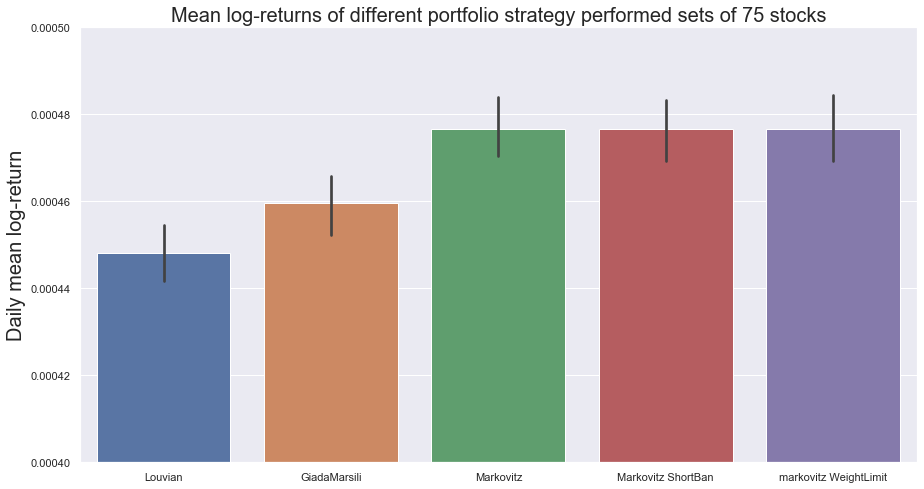

In [7]:
dataf_to_plot = pd.concat([df1, df2,df3,df4,df5], axis=1)
dataf_to_plot.columns = ['Louvian','GiadaMarsili','Markovitz','Markovitz ShortBan','markovitz WeightLimit']
display(dataf_to_plot)

sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(data=dataf_to_plot, estimator= np.mean, ci=95, n_boot=200, units=None, palette=None, saturation=0.75, errcolor='.26')
ax.set_title('Mean log-returns of different portfolio strategy performed sets of 75 stocks',fontsize = 20)
ax.set(ylim=(0.0004, 0.0005))
ax.set_ylabel("Daily mean log-return",fontsize = 20);

In [8]:
scipy.stats.ttest_ind(df1, df2)

Ttest_indResult(statistic=-2.295879416862903, pvalue=0.021682786592702175)

In [9]:
scipy.stats.ttest_ind(df1, df3)

Ttest_indResult(statistic=-5.330393867010811, pvalue=9.800098380573651e-08)

In [10]:
scipy.stats.ttest_ind(df2, df3)

Ttest_indResult(statistic=-3.2064721137507313, pvalue=0.0013437352621684803)

In [13]:
find_annualized_sharpe_rateo(df1)

0.6117263246372858

In [14]:
find_annualized_sharpe_rateo(df2)

0.6366085809717809

In [15]:
find_annualized_sharpe_rateo(df3)

0.5797478847819918

In [16]:
df1 = pd.read_csv('logreg_M_lou_ewew.csv')
df1 = df1['0']

df2 = pd.read_csv('logreg_M_GM_ewew.csv')
df2 = df2['0']

df3 = pd.read_csv('logreg_M_MK_free.csv')
df3 = df3['0']

df4 = pd.read_csv('logreg_M_MK_shortban.csv')
df4 = df4['0']

df5 = pd.read_csv('logreg_M_MK_weigthslimit.csv')
df5 = df5['0']

,louvian_ew,GiadaMarsili_ew,markovitzfree,markovitzSBAN,markovitzWL
0,-0.005905,-0.007246,-0.005148,-0.005148,-0.005148
1,-0.002921,-0.003577,0.000362,0.000362,0.000362
2,-0.010052,-0.007994,-0.002709,-0.002709,-0.002709
3,-0.006866,-0.007524,-0.001253,-0.001253,-0.001253
4,-0.006088,-0.004826,-0.015139,-0.015139,-0.015139
...,...,...,...,...,...
10664995,0.023049,0.022969,0.024211,0.024211,0.024211
10664996,-0.000946,-0.000741,0.007509,0.007509,0.007509
10664997,0.006575,0.006662,0.014797,0.014797,0.014797
10664998,-0.000647,-0.000578,-0.017273,-0.017273,-0.017273


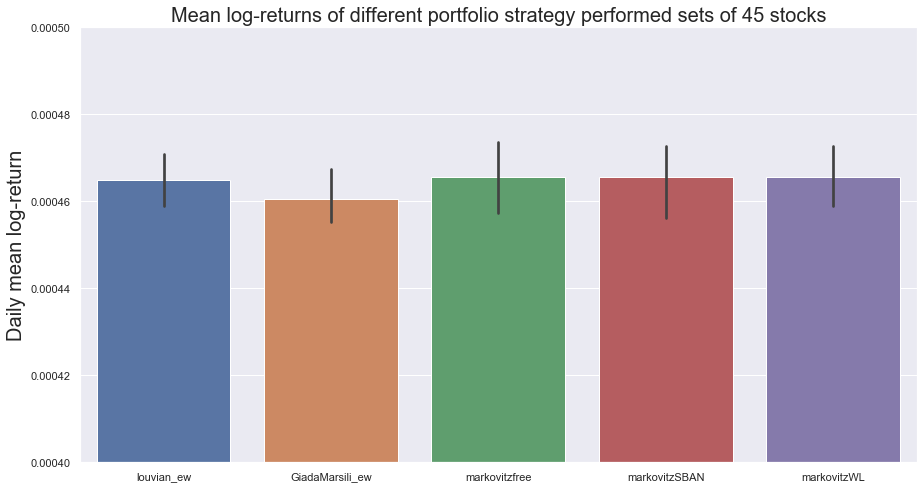

In [17]:
dataf_to_plot = pd.concat([df1, df2,df3,df4,df5], axis=1)
dataf_to_plot.columns = ['louvian_ew','GiadaMarsili_ew','markovitzfree','markovitzSBAN','markovitzWL']
display(dataf_to_plot)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(data=dataf_to_plot, estimator= np.mean, ci=95, n_boot=200, units=None, palette=None, saturation=0.75, errcolor='.26')
ax.set_title('Mean log-returns of different portfolio strategy performed sets of 45 stocks',fontsize = 20)
ax.set(ylim=(0.0004, 0.0005))
ax.set_ylabel("Daily mean log-return",fontsize = 20);

In [18]:
scipy.stats.ttest_ind(df1, df2)

Ttest_indResult(statistic=0.8529681444422077, pvalue=0.39367697956435366)

In [19]:
scipy.stats.ttest_ind(df1, df3)

Ttest_indResult(statistic=-0.10925808052487862, pvalue=0.9129977954112318)

In [20]:
scipy.stats.ttest_ind(df2, df3)

Ttest_indResult(statistic=-0.9029685600397793, pvalue=0.3665425916003088)

In [21]:
find_annualized_sharpe_rateo(df1)

0.6160570834531507

In [22]:
find_annualized_sharpe_rateo(df2)

0.6268967752368674

In [23]:
find_annualized_sharpe_rateo(df3)

0.539196467043704

In [24]:
df1 = pd.read_csv('logreg_S_lou_ewew.csv')
df1 = df1['0']

df2 = pd.read_csv('logreg_S_GM_ewew.csv')
df2 = df2['0']

df3 = pd.read_csv('logreg_S_MK_free.csv')
df3 = df3['0']

df4 = pd.read_csv('logreg_S_MK_shortban.csv')
df4 = df4['0']

df5 = pd.read_csv('logreg_S_MK_weigthslimit.csv')
df5 = df5['0']

,louvian_ew,GiadaMarsili_ew,markovitzfree,markovitzSBAN,markovitzWL
0,-0.007552,-0.008637,-0.009224,-0.009224,-0.009224
1,-0.003740,-0.005522,0.000000,0.000000,0.000000
2,-0.011318,-0.009475,-0.000255,-0.000255,-0.000255
3,-0.004857,-0.003743,-0.000207,-0.000207,-0.000207
4,-0.007379,-0.006779,-0.000624,-0.000624,-0.000624
...,...,...,...,...,...
10664995,0.020496,0.019751,0.024464,0.024464,0.024464
10664996,0.002044,0.002893,-0.010119,-0.010119,-0.010119
10664997,0.006316,0.006529,0.004751,0.004751,0.004751
10664998,0.000228,0.000949,-0.006543,-0.006543,-0.006543


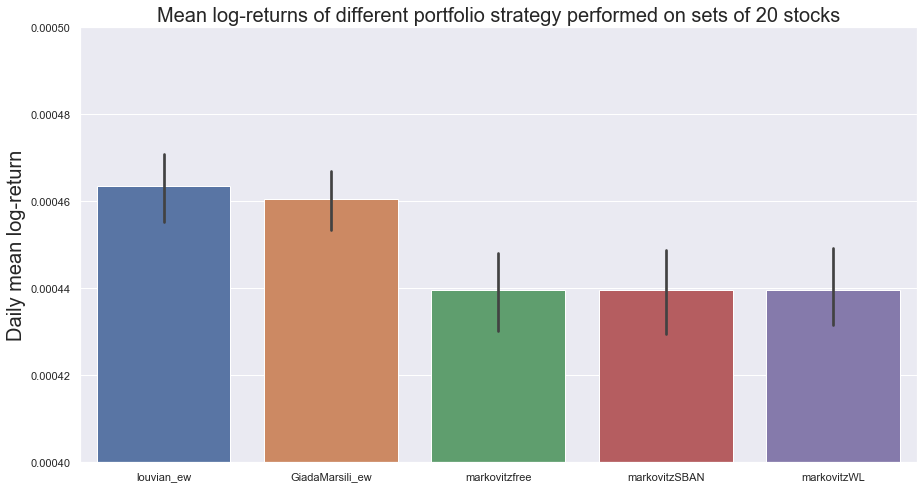

In [25]:
dataf_to_plot = pd.concat([df1, df2,df3,df4,df5], axis=1)
dataf_to_plot.columns = ['louvian_ew','GiadaMarsili_ew','markovitzfree','markovitzSBAN','markovitzWL']
display(dataf_to_plot)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(data=dataf_to_plot, estimator= np.mean, ci=95, n_boot=200, units=None, palette=None, saturation=0.75, errcolor='.26')
ax.set_title('Mean log-returns of different portfolio strategy performed on sets of 20 stocks',fontsize = 20)
ax.set(ylim=(0.0004, 0.0005))
ax.set_ylabel("Daily mean log-return",fontsize = 20);

In [26]:
scipy.stats.ttest_ind(df1, df2)

Ttest_indResult(statistic=0.5442101055887613, pvalue=0.5862969042164261)

In [27]:
scipy.stats.ttest_ind(df1, df3)

Ttest_indResult(statistic=4.006162683387767, pvalue=6.1713361093078e-05)

In [28]:
scipy.stats.ttest_ind(df2, df3)

Ttest_indResult(statistic=3.524954042189258, pvalue=0.0004235571541014601)

In [29]:
find_annualized_sharpe_rateo(df1)

0.5998884417277324

In [30]:
find_annualized_sharpe_rateo(df2)

0.5984025981917844

In [31]:
find_annualized_sharpe_rateo(df3)

0.46577384545681305